In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [58]:
our_color_palette = {"WT": "#F2C14E", # yellow
                     "W": "#F2C14E", # yellow
                     "IP": "#79ADDC", # blue
                     "I": "#79ADDC", # blue
                     "KO": "#B279A7", # purple
                     "K": "#B279A7", # purple
                    } 
treatments_list = ["W", "I", "K"]
passages_list = ["p1", "p2", "p3", "p5", "p10"]
replicates_list = ['a', 'b', 'c']

In [59]:
# define protein 

proteins = {
    "1A": (709, 1206),
    "2A": (1207, 1278),
    "2B": (1279, 1692),
    "2C": (1693, 2925),
    "3A": (2926, 3361),
    "3B": (3364, 3432),
    "3C": (3433, 4368),
    "RdRp": (4369, 6022),
    "VP1": (6217, 7065),
    "VP4": (7066, 7236),
    "VP2": (7237, 8121),
    "VP3": (8122, 8902),
           }

In [60]:
length_crpv = 9185

In [61]:
# load diveristy 

fname = "all_snpgenie_site_results.csv"
df = pd.read_csv(fname)

In [62]:
df_pis_protein = pd.DataFrame() 

for virus in ['CrPV']:
    for sample in df['passage'].unique():
        for protein in proteins.items():
            protein_id = protein[0]
            protein_start = protein[1][0]
            protein_end = protein[1][1]
            protein_length = protein_end - protein_start

            df_temp = df[df['virus']== virus]
            df_temp = df_temp[df_temp['passage']==sample]
            df_temp = df_temp[df_temp['site'].isin(list(range(protein_start,protein_end+1 )))]
            avg_pi = df_temp['pi'].sum()/protein_length

            mean_pis = {
                        'virus': [virus], 
                        'sample': sample, 
                        'protein': protein_id,
                        'avg_pi': avg_pi, 
                    }

            df_pis_protein = pd.concat([pd.DataFrame(mean_pis),df_pis_protein], ignore_index=True)

In [63]:
df_pis_protein['genotype'] = df_pis_protein['sample'].str.split("_").str[0]
df_pis_protein['rep'] = df_pis_protein['sample'].str.split("_").str[-1]
df_pis_protein['passage'] = df_pis_protein['sample'].str.split("_").str[1].str.split("p").str[-1].astype(int)

df_pis_protein.head()

,virus,sample,protein,avg_pi,genotype,rep,passage
0,CrPV,W_p10_c,VP3,0.000278,W,c,10
1,CrPV,W_p10_c,VP2,0.000316,W,c,10
2,CrPV,W_p10_c,VP4,0.000104,W,c,10
3,CrPV,W_p10_c,VP1,0.000114,W,c,10
4,CrPV,W_p10_c,RdRp,0.000195,W,c,10


In [64]:
df_pis_protein['genotype'].unique()

array(['W', 'I', 'K', 'parental'], dtype=object)

In [65]:
df_pis_protein = df_pis_protein[df_pis_protein['genotype']!='parental']

In [66]:
df_pi_summary = df_pis_protein[
    ['protein', 'avg_pi', 'genotype', 'passage', 'rep']
].groupby(by=['genotype', 'rep', 'protein']).mean().reset_index()

/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_81691/1048459402.py:5: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.1}` instead.

  g = sns.catplot(df_pi_summary,


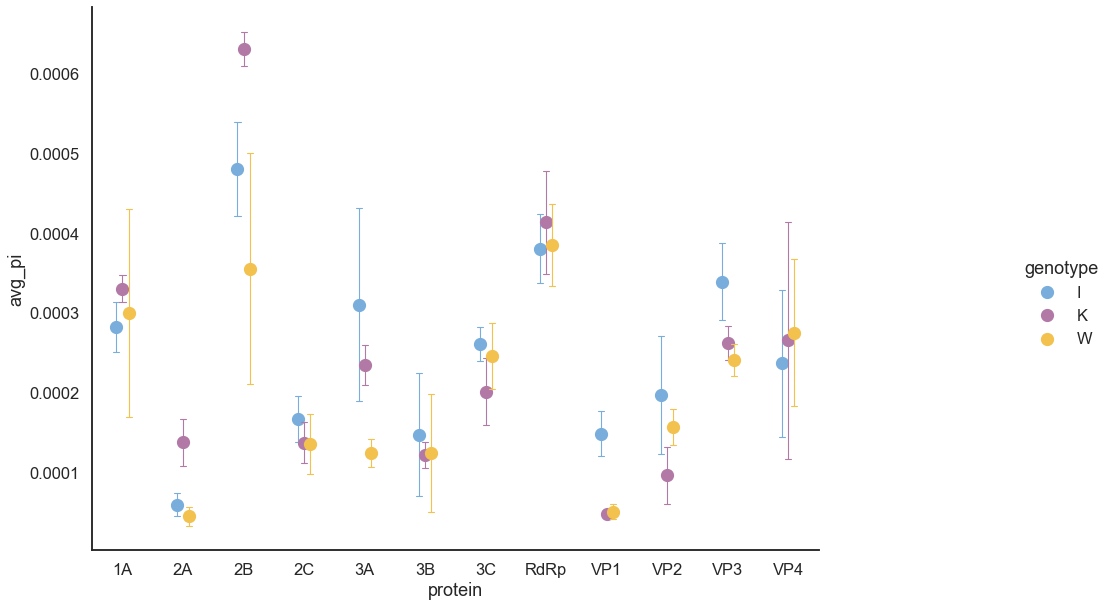

In [67]:
sns.set_context("talk") 
sns.set_style('white')


g = sns.catplot(df_pi_summary, 
                y='avg_pi',
                hue='genotype', 
                x='protein', 
                palette=our_color_palette, 
                errorbar="se",
                linestyle='',
                errwidth=1.1, 
                dodge=0.2,
                capsize=0.1,
                kind='point')

# If you need to adjust after creation, you can also use:
g.fig.set_size_inches(20, 10)



In [68]:
df_pi_summary

,genotype,rep,protein,avg_pi,passage
0,I,a,1A,0.000346,4.2
1,I,a,2A,0.000033,4.2
2,I,a,2B,0.000501,4.2
3,I,a,2C,0.000160,4.2
4,I,a,3A,0.000540,4.2
...,...,...,...,...,...
103,W,c,RdRp,0.000441,4.2
104,W,c,VP1,0.000054,4.2
105,W,c,VP2,0.000113,4.2
106,W,c,VP3,0.000281,4.2


In [69]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [27]:
%%R -i df_pi_summary 

library(rstatix)

# Two-way mixed ANOVA test
res.aov <- anova_test(
  data = df_pi_summary, 
    dv = avg_pi, 
    wid = rep,
    between = genotype, 
    within = protein
  )
get_anova_table(res.aov)

/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
R[write to console]: Warnung:
R[write to console]:  The 'wid' column contains duplicate ids across between-subjects variables. Automatic unique id will be created



ANOVA Table (type II tests)

            Effect DFn DFd      F        p p<.05   ges
1         genotype   2   6  1.594 2.79e-01       0.051
2          protein  11  66 12.394 2.96e-12     * 0.650
3 genotype:protein  22  66  0.831 6.77e-01       0.199


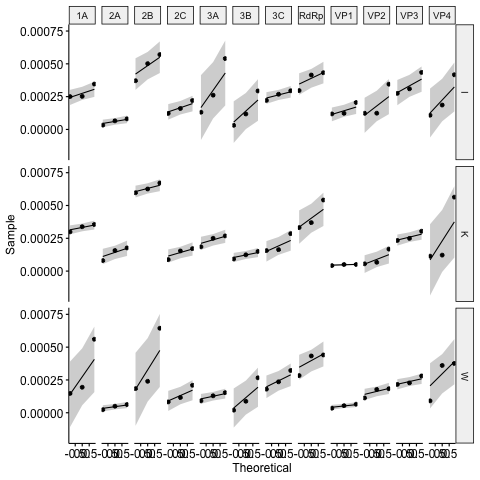

In [28]:
%%R

ggqqplot(df_pi_summary, "avg_pi")+
  facet_grid (genotype~protein)

In [70]:
%%R 

library(rstatix)
library(dplyr)
df_pi_summary %>%
  group_by(genotype) %>%
  levene_test(avg_pi~protein)

# A tibble: 3 × 5
  genotype   df1   df2 statistic     p
  <chr>    <int> <int>     <dbl> <dbl>
1 I           11    24     0.623 0.791
2 K           11    24     0.616 0.798
3 W           11    24     0.642 0.776


In [71]:
%%R 

df_pi_summary %>%
  group_by(genotype, protein) %>%
  summarise(var(avg_pi)) %>%
  as.data.frame()

`summarise()` has grouped output by 'genotype'. You can override using the
`.groups` argument.
   genotype protein  var(avg_pi)
1         I      1A 2.984829e-09
2         I      2A 6.011268e-10
3         I      2B 1.023746e-08
4         I      2C 2.444831e-09
5         I      3A 4.367513e-08
6         I      3B 1.782972e-08
7         I      3C 1.378234e-09
8         I    RdRp 5.477749e-09
9         I     VP1 2.389320e-09
10        I     VP2 1.630224e-08
11        I     VP3 7.038874e-09
12        I     VP4 2.577105e-08
13        K      1A 8.277706e-10
14        K      2A 2.609609e-09
15        K      2B 1.417125e-09
16        K      2C 1.942468e-09
17        K      3A 1.902455e-09
18        K      3B 8.375477e-10
19        K      3C 5.275568e-09
20        K    RdRp 1.255110e-08
21        K     VP1 2.499956e-11
22        K     VP2 3.768848e-09
23        K     VP3 1.348821e-09
24        K     VP4 6.627777e-08
25        W      1A 5.112888e-08
26        W      2A 4.050564e-10
27        W   

In [72]:
%%R 

box_m(df_pi_summary[ "avg_pi"], df_pi_summary$genotype)

# A tibble: 1 × 4
  statistic p.value parameter method                                            
      <dbl>   <dbl>     <dbl> <chr>                                             
1      1.45   0.485         2 Box's M-test for Homogeneity of Covariance Matric…


In [73]:
%%R

model <- aov(avg_pi ~ genotype * protein + Error(rep/protein), data = df_pi_summary)

summary(model)



Error: rep
          Df    Sum Sq   Mean Sq F value Pr(>F)
Residuals  2 2.022e-08 1.011e-08               

Error: rep:protein
          Df    Sum Sq   Mean Sq F value   Pr(>F)    
protein   11 1.531e-06 1.392e-07   19.45 7.71e-09 ***
Residuals 22 1.575e-07 7.160e-09                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: Within
                 Df    Sum Sq   Mean Sq F value Pr(>F)
genotype          2 4.460e-08 2.231e-08   1.654  0.202
genotype:protein 22 2.055e-07 9.340e-09   0.692  0.825
Residuals        48 6.476e-07 1.349e-08               


In [79]:
%%R 

library(emmeans)

# Assuming your contrasts are stored in a data frame called 'contrasts'
# If not, first convert the emmeans output to a data frame
contrasts_df <- as.data.frame(pairs(emmeans(model, ~ protein, adjust = "bonferroni")))

# Filter significant contrasts
significant_contrasts <- contrasts_df[contrasts_df$p.value < 0.05, ]

# Sort by p-value
significant_contrasts <- significant_contrasts[order(significant_contrasts$p.value), ]

# Display results
print(significant_contrasts)

R[write to console]: Note: re-fitting model with sum-to-zero contrasts

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



 contrast        estimate           SE df t.ratio p.value
 2A - 2B    -0.0004085927 3.988628e-05 22 -10.244  <.0001
 2B - VP1    0.0004069651 3.988628e-05 22  10.203  <.0001
 2B - 3B     0.0003580482 3.988628e-05 22   8.977  <.0001
 2B - 2C     0.0003424794 3.988628e-05 22   8.586  <.0001
 2B - VP2    0.0003389215 3.988628e-05 22   8.497  <.0001
 2A - RdRp  -0.0003128007 3.988628e-05 22  -7.842  <.0001
 RdRp - VP1  0.0003111730 3.988628e-05 22   7.802  <.0001
 2B - 3A     0.0002661562 3.988628e-05 22   6.673  0.0001
 3B - RdRp  -0.0002622561 3.988628e-05 22  -6.575  0.0001
 2B - 3C     0.0002531531 3.988628e-05 22   6.347  0.0001
 2C - RdRp  -0.0002466874 3.988628e-05 22  -6.185  0.0002
 RdRp - VP2  0.0002431295 3.988628e-05 22   6.096  0.0002
 2B - VP4    0.0002297681 3.988628e-05 22   5.761  0.0004
 1A - 2A     0.0002238259 3.988628e-05 22   5.612  0.0006
 1A - VP1    0.0002221982 3.988628e-05 22   5.571  0.0006
 2B - VP3    0.0002083594 3.988628e-05 22   5.224  0.0014
 2A - VP3   -0